In [1]:
import numpy as np
import pandas as pd 
import json
import math

# for data visualization
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import ensemble

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spotify-dataset-19212020-160k-tracks/data_o.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/dict_artists.json
/kaggle/input/spotify-dataset-19212020-160k-tracks/artists.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_artist_o.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/tracks.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_genres_o.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_year_o.csv


In [2]:
tracks = pd.read_csv('/kaggle/input/spotify-dataset-19212020-160k-tracks/tracks.csv')
artists = pd.read_csv('/kaggle/input/spotify-dataset-19212020-160k-tracks/artists.csv')
genres = pd.read_csv('/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_genres_o.csv')
years = pd.read_csv('/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_year_o.csv')

In [3]:
with open('/kaggle/input/spotify-dataset-19212020-160k-tracks/dict_artists.json') as f:
    artists_related = json.load(f)

## EDA and Pre-Processing

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [5]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104349 entries, 0 to 1104348
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1104349 non-null  object 
 1   followers   1104336 non-null  float64
 2   genres      1104349 non-null  object 
 3   name        1104349 non-null  object 
 4   popularity  1104349 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 42.1+ MB


In [6]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [7]:
years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [8]:
tracks.describe() 

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [9]:
fig = px.histogram(tracks, x="popularity", nbins=40, title="Histogram of Tracks' popularity")
fig.show()

In [10]:
tracks["release_year"] = pd.to_datetime(tracks["release_date"]).dt.year
tracks.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_year'],
      dtype='object')

In [11]:
# Removing Redundant variables
tracks_ml = tracks[['popularity', 'duration_ms', 'explicit','release_year', 'danceability', 'energy',
                   'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                   'liveness', 'valence', 'tempo', 'time_signature']]

In [12]:
tracks_2020_ml = tracks_ml.query("release_year == 2020").drop(["release_year"], axis=1)

Text(0.5, 1.0, "Correlations Heatmap between Audio Features, Based on 2020's Tracks")

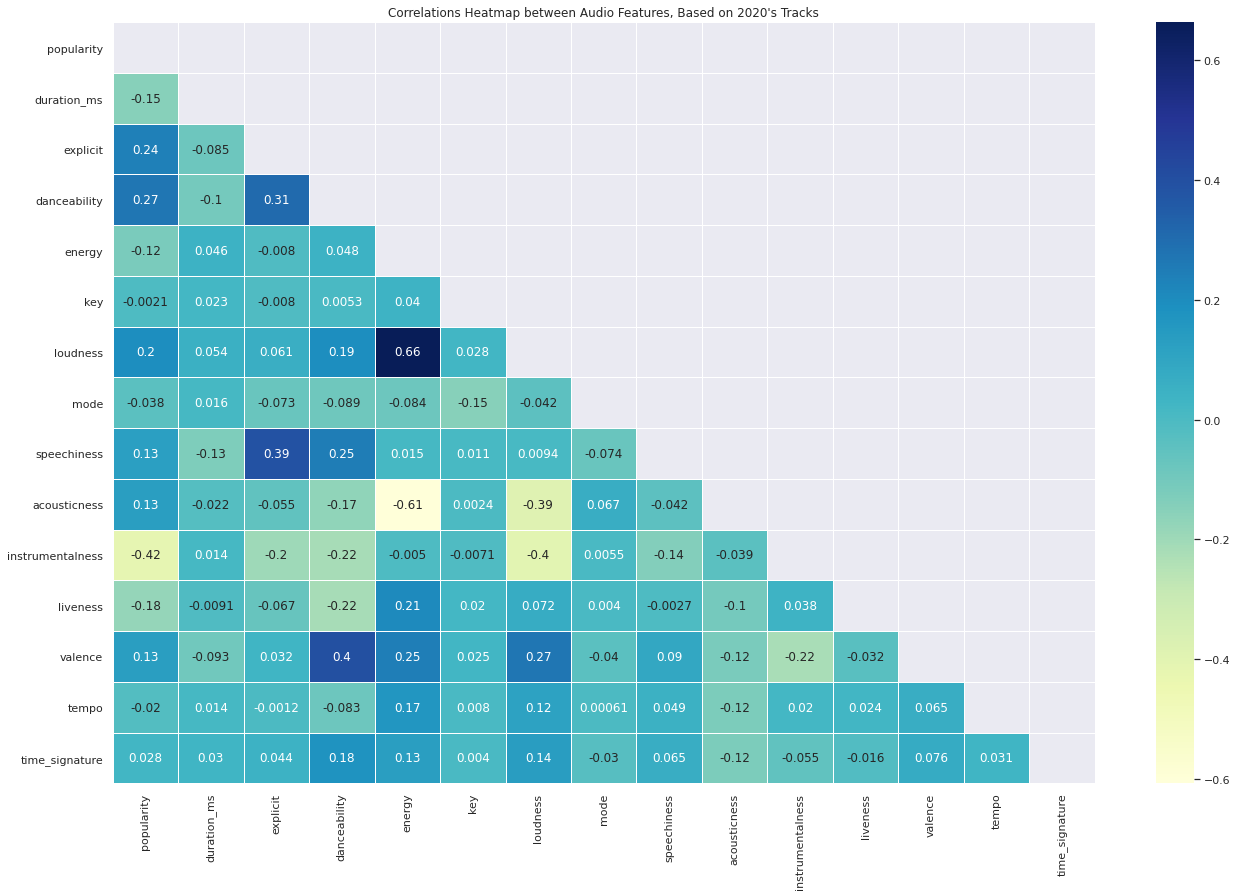

In [13]:
sns.set(rc={'figure.figsize':(22,14)})
sns.heatmap(tracks_2020_ml.corr(), linewidths=.5, annot=True, cmap="YlGnBu",
           mask=np.triu(np.ones_like(tracks_2020_ml.corr(), dtype=np.bool)))\
    .set_title("Correlations Heatmap between Audio Features, Based on 2020's Tracks")

**Analysis:**     
1. Acousticness is highly negative correlated to energy and loudness.      
2. energy and loudness are highly positve correlated to each other.
3. Instrumentalness is highly negative correlated to loudness. 
4. Danceability and valence have a highly positve correlation.
5. Popularity is highly positve correlated to explicit and danceability, and it is highly negative correlated to instrumentalness.

In [14]:
cols = tracks_2020_ml.columns
for col in cols:
    fig = px.histogram(tracks_2020_ml, x=col, title="Histogram of Tracks' " + col + ", 2020")
    fig.show()

**Analysis:**     
1. From the histogram of popularity, most of song and rated in 0 to 1 range, and the range over 20 shows a normal distribution.      
2. The distribution of duration_ms, danceability, energy, loudness, liveness and valence are normal.    
3. The most of songs' time_signature is 4.            
4. The distribution of speechiness, acousticness and instrumentalness are right-skewed.

In [15]:
X, y = tracks_2020_ml[cols[1:]], tracks_2020_ml[cols[0]]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

## Modeling

In [16]:
# define models
models = {
    "OLS": linear_model.LinearRegression(),
    "Ridge": linear_model.Ridge(),
    "Lasso": linear_model.Lasso(),
    "Bayesian": linear_model.BayesianRidge(), 
    "SVM": svm.SVR(),
    "RandomForestReg": ensemble.RandomForestRegressor(),
    "AdaBoostReg": ensemble.AdaBoostRegressor(),
    "GradientBoostingReg": ensemble.GradientBoostingRegressor()
}

In [17]:
# cross validate to fit and score
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in models.keys():
    cv_res = cross_validate(models[key], X_train, y_train, 
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error',
                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean(),
        }
    cv_results = cv_results.append(res, ignore_index=True)
    print("CV for model:", key, "done.")
    
# show and compare results
cv_results["train_score"] = cv_results["train_score"].apply(abs)
cv_results["test_score"] = cv_results["test_score"].apply(abs)
sorted_cv_results = cv_results.sort_values(['train_score', 'test_score'])
sorted_cv_results

CV for model: OLS done.
CV for model: Ridge done.
CV for model: Lasso done.
CV for model: Bayesian done.
CV for model: SVM done.
CV for model: RandomForestReg done.
CV for model: AdaBoostReg done.
CV for model: GradientBoostingReg done.


,model,train_score,test_score,fit_time,score_time
5,RandomForestReg,6.624168,17.559196,11.521988,0.080788
7,GradientBoostingReg,17.028612,18.139895,3.061110,0.007380
6,AdaBoostReg,19.625274,19.818931,0.678273,0.008792
0,OLS,19.724484,19.795950,0.119207,0.003095
1,Ridge,19.724503,19.795857,0.010066,0.002927
3,Bayesian,19.724672,19.795816,0.012089,0.003016
2,Lasso,21.169560,21.220557,0.009064,0.002912
4,SVM,22.703703,22.709533,5.931469,0.781788


## Evaluate  Best Model on Testing Set
Considering the difference between the train and test score in the cross validatation on training set, the RandomForestReg model is a little over fitting. However, this model gives the best test score, so we use it as our best model and evaluate it on testing set.

In [18]:
best_model_key = sorted_cv_results.head(1).model.values[0]
print("best_model_choosed:", best_model_key)
best_model = models[best_model_key].fit(X_train, y_train)
print('root_mean_squared_error:', np.sqrt(mean_squared_error(y_test, best_model.predict(X_test))))

best_model_choosed: RandomForestReg
root_mean_squared_error: 17.23010123181604


## Model Error Analysis

In [19]:
test_set = y_test.reset_index()
test_set["predicted"] = best_model.predict(X_test)
test_set["abs_error"] = abs(test_set["predicted"] - test_set["popularity"])
test_set = test_set.sort_values("abs_error", ascending=False)
test_set

,index,popularity,predicted,abs_error
2136,159063,8,77.703333,69.703333
2730,158738,9,74.300000,65.300000
3916,158973,6,68.980000,62.980000
431,218853,9,71.930000,62.930000
2797,75024,0,60.762000,60.762000
...,...,...,...,...
3306,129230,0,0.000000,0.000000
3881,73667,0,0.000000,0.000000
334,345010,45,45.000000,0.000000
2653,129220,0,0.000000,0.000000


In [20]:
test_set.describe()

,index,popularity,predicted,abs_error
count,4600.000000,4600.000000,4600.000000,4600.000000
mean,332409.154783,44.931739,44.573711,12.876417
std,153948.223135,23.261910,15.381209,11.450012
min,39603.000000,0.000000,0.000000,0.000000
25%,210239.250000,35.000000,37.727500,4.359583
50%,344947.500000,51.000000,49.938333,9.847083
75%,456530.250000,62.000000,55.330000,17.831000
max,586669.000000,97.000000,84.048000,69.703333


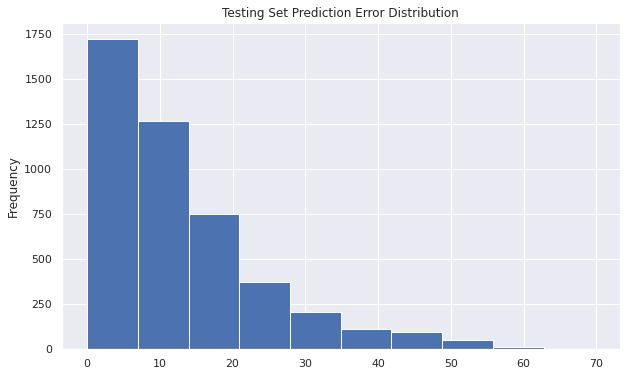

In [21]:
test_set.abs_error.plot(kind='hist', title="Testing Set Prediction Error Distribution", figsize=(10,6));

In [22]:
print("abs_error over 50 prediction percentage:", end=" ")
print(test_set.query("abs_error > 50").abs_error.count() / test_set.abs_error.count())

abs_error over 50 prediction percentage: 0.01391304347826087


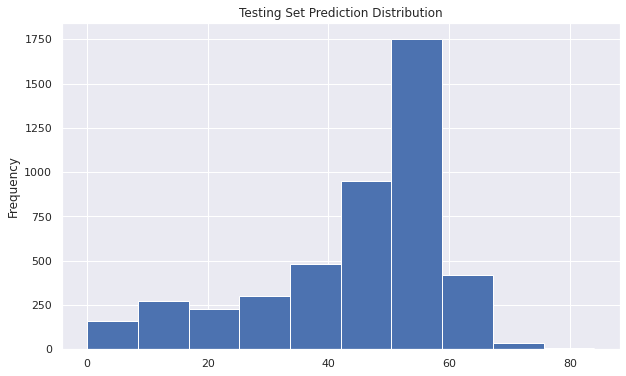

In [23]:
test_set.predicted.plot(kind='hist', title="Testing Set Prediction Distribution", figsize=(10,6));

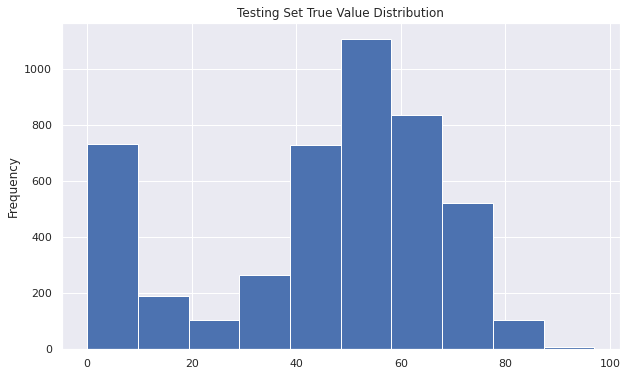

In [24]:
test_set.popularity.plot(kind='hist', title="Testing Set True Value Distribution", figsize=(10,6));

In [25]:
print("nagetive prediction percentage:", end=" ")
print(test_set.query("predicted < 0").predicted.count() / test_set.predicted.count())

nagetive prediction percentage: 0.0


**Analysis:**    
In the prediction, only 1.26% of testing data have abs_root_mean_squared_error > 50, most of the error is bewteen 0 to 20.   
The mean abs_root_mean_squared_error is 12.897846 and the median is 9.95.    
In the dataset, part (popularity over 20) of the popularity true value is normally distributed, but another part (popularity under 20) is not. Since one of the assumptions of the regression is normally distributed, the predicted value is normally distributed. This is one of the causes of the error.

## Improved Modeling
Since one of the assumptions of the regression is normally distributed, remove outliers which's popularity <= 20 and re-modeling.

In [26]:
tracks_2020_ml_n = tracks_2020_ml.query("popularity > 20")
X_n, y_n = tracks_2020_ml_n[cols[1:]], tracks_2020_ml_n[cols[0]]
X_n_train, X_n_test, y_n_train, y_n_test = model_selection.train_test_split(X_n, y_n, test_size=0.33, random_state=1)

In [27]:
# cross validate to fit and score
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in models.keys():
    cv_res = cross_validate(models[key], X_n_train, y_n_train, 
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error',
                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean(),
        }
    cv_results = cv_results.append(res, ignore_index=True)
    print("CV for model:", key, "done.")
    
# show and compare results
cv_results["train_score"] = cv_results["train_score"].apply(abs)
cv_results["test_score"] = cv_results["test_score"].apply(abs)
sorted_cv_results = cv_results.sort_values(['train_score', 'test_score'])
sorted_cv_results

CV for model: OLS done.
CV for model: Ridge done.
CV for model: Lasso done.
CV for model: Bayesian done.
CV for model: SVM done.
CV for model: RandomForestReg done.
CV for model: AdaBoostReg done.
CV for model: GradientBoostingReg done.


,model,train_score,test_score,fit_time,score_time
5,RandomForestReg,4.368743,11.561368,8.224549,0.063406
7,GradientBoostingReg,10.820829,11.593370,2.390608,0.006780
6,AdaBoostReg,11.676794,11.828321,0.789459,0.010365
0,OLS,11.875658,11.914923,0.005433,0.002600
1,Ridge,11.875678,11.914806,0.005920,0.002774
3,Bayesian,11.876416,11.915152,0.007765,0.002848
2,Lasso,12.346648,12.362580,0.005564,0.002614
4,SVM,12.396240,12.418065,3.622022,0.494682


## Evaluate NEW Best Model on Testing Set Again
Made a tradeoff the fit time and train/test score of Random Forest and Gradient Boosting regressor, Gradient Boosting regressor is not over fitting and saved more time, so this section will evaluate Gradient Boosting regressor on testing set.

In [28]:
best_model_key = sorted_cv_results.head(1).model.values[0]
print("best_model_choosed:", best_model_key)
n_best_model_rf = models[best_model_key].fit(X_n_train, y_n_train)
print('root_mean_squared_error:', np.sqrt(mean_squared_error(y_n_test, n_best_model_rf.predict(X_n_test))))

best_model_choosed: RandomForestReg
root_mean_squared_error: 11.741274925003504


In [29]:
print("model_choosed: GradientBoostingReg")
n_best_model_gb = models["GradientBoostingReg"].fit(X_n_train, y_n_train)
print('root_mean_squared_error:', np.sqrt(mean_squared_error(y_n_test, n_best_model_gb.predict(X_n_test))))

model_choosed: GradientBoostingReg
root_mean_squared_error: 11.811044825926796


## Error Analysis One More Time

In [30]:
test_set_n = y_n_test.reset_index()
test_set_n["predicted"] = n_best_model_gb.predict(X_n_test)
test_set_n["abs_error"] = abs(test_set_n["predicted"] - test_set_n["popularity"])
test_set_n = test_set_n.sort_values("abs_error", ascending=False)
test_set_n

,index,popularity,predicted,abs_error
800,92811,97,53.841216,43.158784
3085,92814,95,53.921212,41.078788
1043,92813,96,55.728185,40.271815
2324,92832,91,53.951769,37.048231
144,320043,21,57.761692,36.761692
...,...,...,...,...
2787,569987,58,57.983548,0.016452
2017,374629,56,55.983912,0.016088
3031,569990,58,58.013776,0.013776
1645,352837,57,57.005171,0.005171


In [31]:
pd.concat([test_set.describe().add_suffix('_o'), test_set_n.describe().add_suffix('_n')], axis=1)

,index_o,popularity_o,predicted_o,abs_error_o,index_n,popularity_n,predicted_n,abs_error_n
count,4600.000000,4600.000000,4600.000000,4600.000000,3652.000000,3652.00000,3652.000000,3652.000000
mean,332409.154783,44.931739,44.573711,12.876417,355162.371577,55.16046,54.980326,9.349841
std,153948.223135,23.261910,15.381209,11.450012,144386.329939,13.00833,5.223155,7.217723
min,39603.000000,0.000000,0.000000,0.000000,75458.000000,21.00000,27.986928,0.000050
25%,210239.250000,35.000000,37.727500,4.359583,246515.250000,46.00000,53.273893,3.598473
50%,344947.500000,51.000000,49.938333,9.847083,374499.000000,55.00000,55.721366,7.789816
75%,456530.250000,62.000000,55.330000,17.831000,464014.500000,64.00000,58.227917,13.595094
max,586669.000000,97.000000,84.048000,69.703333,586664.000000,97.00000,68.892831,43.158784


After removing outliers, the max abs_error is reduced from 69 to 43, and the mean abs_error is reduced from 12.87 to 9.34.  


## Hyperparameter Tuning

In [32]:
# # Create the parameter grid based on the results of random search 
# param_grid_rf = {
#     'bootstrap': [True],
#     'max_depth': range(50, 101, 50),
#     'max_features': range(5, 10),
#     'min_samples_leaf': range(5, 10),
# #     'min_samples_split': range(2, 7),
#     'n_estimators':  range(10, 101, 20)
# }

# # Instantiate the grid search model
# grid_search_rf = model_selection.GridSearchCV(estimator = models["RandomForestReg"], param_grid = param_grid_rf, 
#                               cv = 2, n_jobs = -1, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the data
# grid_search_rf.fit(X_n_train, y_n_train)
# print("best_params:", grid_search_rf.best_params_)

In [33]:
# best_grid_rf = grid_search_rf.best_estimator_
# print('root_mean_squared_error: ', np.sqrt(mean_squared_error(y_n_test, best_grid_rf.predict(X_n_test))))

In [34]:
# # Create the parameter grid based on the results of random search 
# param_grid_gb = {
#     "loss": ["ls", "lad", "huber", "quantile"],
#     "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
#     "n_estimators": range(10, 201, 50),
# #     "min_samples_leaf": range(5, 10),
# #     "max_depth": range(50, 101, 10),
#     "max_features": range(5, 10)
# }

# # Instantiate the grid search model
# grid_search_gb = model_selection.GridSearchCV(estimator = models["GradientBoostingReg"], param_grid = param_grid_gb, 
#                               cv = 2, n_jobs = -1, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the data
# grid_search_gb.fit(X_n_train, y_n_train)
# print("best_params:", grid_search_gb.best_params_)

In [35]:
# best_grid_gb = grid_search_gb.best_estimator_
# print('root_mean_squared_error: ', np.sqrt(mean_squared_error(y_n_test, best_grid_gb.predict(X_n_test))))

## Can 2020 Model Predict 2019 and 2021 Songs' Popularity?

In [36]:
tracks_2021_ml = tracks_ml.query("release_year == 2021 & popularity > 20").drop(["release_year"], axis=1)
X_2021, y_2021 = tracks_2021_ml[cols[1:]], tracks_2021_ml[cols[0]]
print('root_mean_squared_error on 2021 songs:', np.sqrt(mean_squared_error(y_2021, n_best_model_gb.predict(X_2021))))

root_mean_squared_error on 2021 songs: 13.820619355481034


In [37]:
tracks_2019_ml = tracks_ml.query("release_year == 2019 & popularity > 20").drop(["release_year"], axis=1)
X_2019, y_2019 = tracks_2019_ml[cols[1:]], tracks_2019_ml[cols[0]]
print('root_mean_squared_error on 2019 songs:', np.sqrt(mean_squared_error(y_2019, n_best_model_gb.predict(X_2019))))

root_mean_squared_error on 2019 songs: 12.109526507849784


Thus, 2020 Model have the similar prediction error on 2019 and 2021 data set.